# Procedural monomer fragment generation using rules-based reactions

In constructing polymer systems for MD, there are a handful of core issues that one will frequently encounter:
* When working with polymers, it is virtually always the case that the repeat units in a polymer chain are _not_ chemically identical to the corresponding monomers  
* Also, when setting up polymeric systems for MD, particularly for high-throughput applications, it is desireable to set up many functionally-similar monomers which follow the same polymerization mechanism
* Finally, the [monomer fragment specification we prescribe](https://pubs.acs.org/doi/10.1021/acs.jcim.3c01691) can be a bit unwieldy and tough to parse, and generating these fragment template by hand is error-prone

With these facts in mind, the polymerist toolkit provides utilities which remedy all of the above, demonstrated here

In [1]:
from rdkit import Chem
from IPython.display import display

from pathlib import Path
from polymerist.genutils.fileutils.pathutils import assemble_path

RXNS_DIR = Path('rxn_demos')
RXNS_DIR.mkdir(exist_ok=True)

# Example polymer system: conjugation of thiophenes with linear alkyl tails (head-to-tail)

### Defining reactant templates and side products

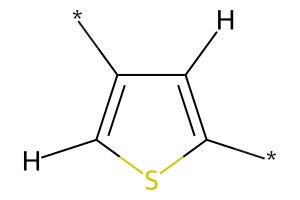

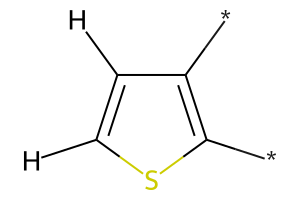

In [2]:
from polymerist.rdutils import rdkdraw
from polymerist.monomers.specification import expanded_SMILES, SANITIZE_AS_KEKULE


rdkdraw.set_rdkdraw_size(200, 3/2)
dihydrogen = Chem.MolFromSmarts('[H]-[H]') # this is a reaction byproduct; these need to be explicitly defined on the template
template_smiles_raw = [ # these two templates describe singly-fragmented thiophenes with a single R-group on the 3-site and chain on the 2- and 4-sites, respectively
    'S1C=C(C=C1(*))*',
    'S1C(*)=C(C=C1)*',
] 

reactant_templates, template_smiles = [], []
for smiles in template_smiles_raw:
    exp_smiles = expanded_SMILES(smiles, assign_map_nums=False)
    template_mol = Chem.MolFromSmiles(exp_smiles, sanitize=False)
    Chem.SanitizeMol(template_mol, sanitizeOps=SANITIZE_AS_KEKULE)

    display(template_mol)
    template_smiles.append(exp_smiles)
    reactant_templates.append(template_mol)

### Assembling a reaction template

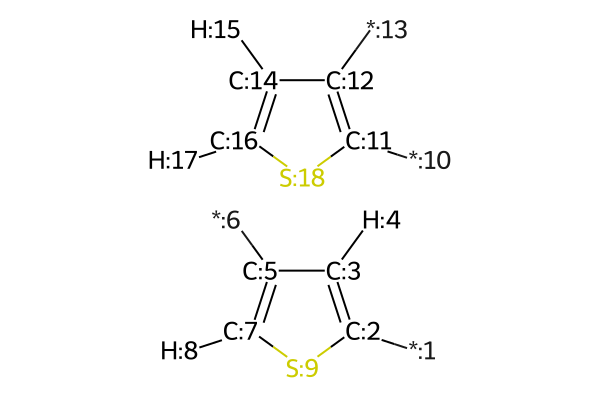

In [3]:
from polymerist.rdutils.reactions.assembly import ReactionAssembler


rdkdraw.set_rdkdraw_size(400, 3/2)
assem = ReactionAssembler(
    reactive_groups=reactant_templates,
    rxn_name='thiophene_conjugation',
)
display(assem.reactants)

This is where we defined which bonds should move where, and which byproducts (if any) should be washed away

In [4]:
assem.bond_derangement = {
    8  : (7, 17), # H8 , which was connected to C7 , should reconnect to H17
    16 : (17, 7), # C16, which was connected to H17, should reconnect to C7
}
assem.byproducts = (dihydrogen,) # unmap the hydrogen byproduct, to avoid gumming up the reaction

Here we finally put together our reaction, watching first as all the old template bonds are broken and afterwards how all new bonds are formed

8 --x-> 7


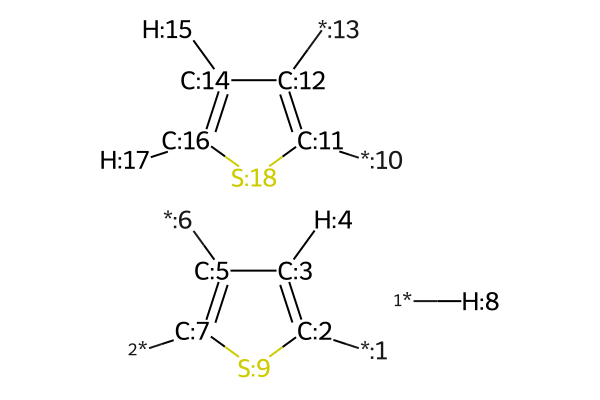

16 --x-> 17


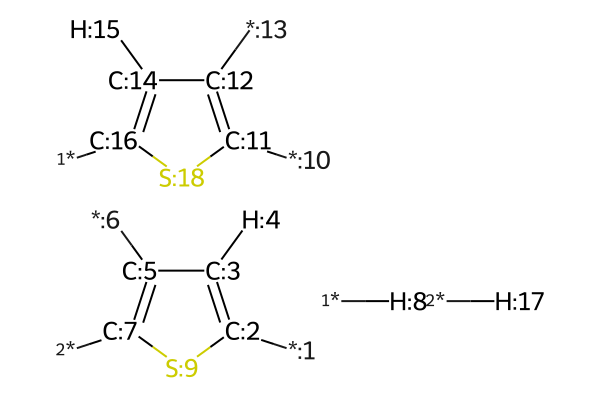

8 ----> 17


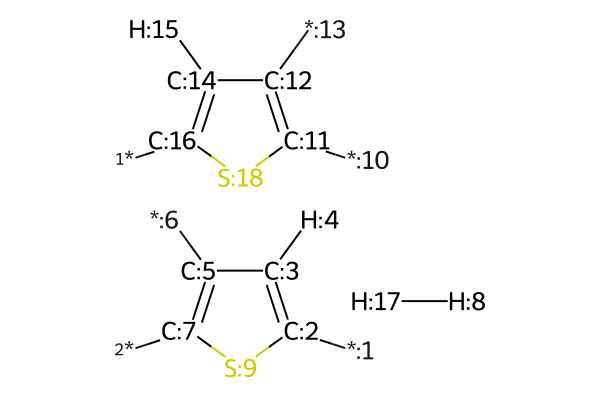

16 ----> 7


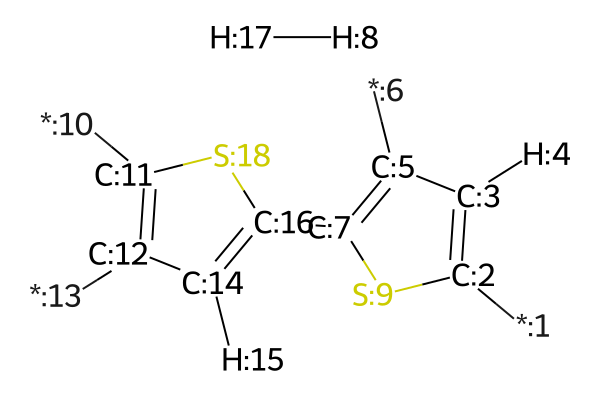

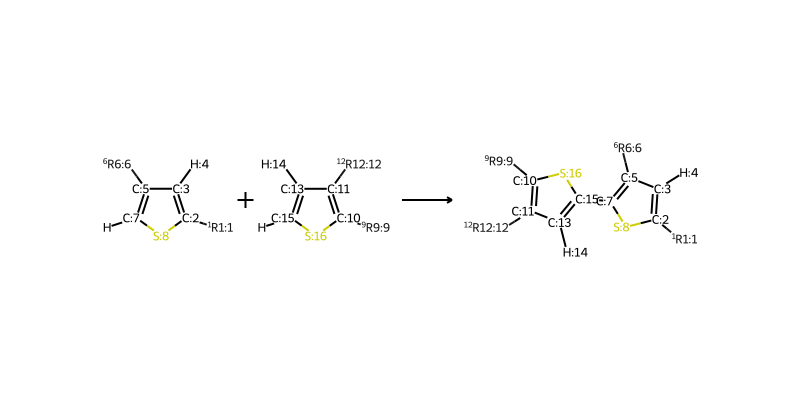

In [5]:
from rdkit.Chem.rdChemReactions import (
    SanitizeRxn,
    SanitizeRxnAsMols,
    SanitizeFlags as SanitizeFlagsRxn
)


rxn = assem.assemble_rxn(show_steps=True)
SanitizeRxn(      rxn, sanitizeOps=SanitizeFlagsRxn.SANITIZE_ALL & ~SanitizeFlagsRxn.SANITIZE_MERGEHS) # perform all rxn clenup operations EXCEPT deleting hydrogens (we need those!)
SanitizeRxnAsMols(rxn, sanitizeOps=SANITIZE_AS_KEKULE) # removes aromatic flags from reactant and product templates
display(rxn)

rxn_path = assemble_path(RXNS_DIR, 'thiophene', extension='rxn')
rxn.to_rxnfile(rxn_path) # save reaction to file to use later

# Applying our reaction template to a some monomers to enumerate chain fragments

### Defining reactive monomers (chemically exact to synthesis starting products)
Here you can specify **ANY** sidechain for the 3-site of a thiophene; they can all be generated by the same reaction template  
This is the real power of the rules-based reaction approach; one template to rule them all (for a given polymerization mechanism)

In [6]:
# Try out any sidechain with its SMILES!

# sidechain_smiles = '[H]' # bare thiophene
# sidechain_smiles : str = 'CCCCCC'   # generic hexyl substituent (for poly(3-hexylthiophene) [P3HT])
# sidechain_smiles : str = 'c1ccccc1' # phenyl chain to show this works for aromatic groups
sidechain_smiles = 'C1=NNN=N1' # tetrazole ring, to show this works for less common groups too :)

5-thiophen-3-yl-2h-tetrazole_head


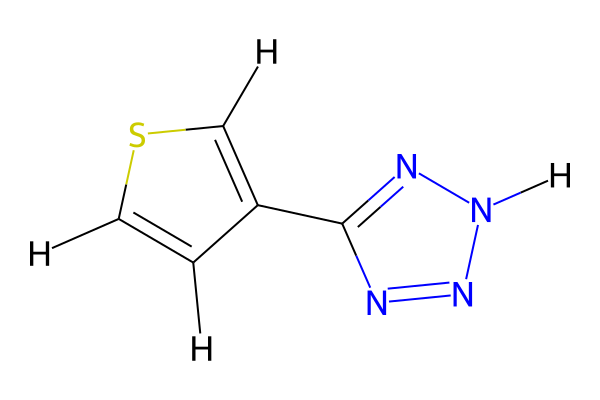

5-thiophen-3-yl-2h-tetrazole_tail


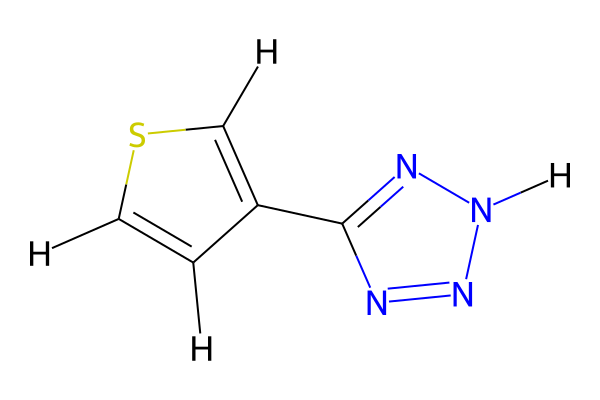

In [7]:
import cirpy
import pubchempy as pcp


# produce chemically-cmplete monomer molecule representation
monomer_smiles = f'S1C=C(C=C1){sidechain_smiles}'
exp_monomer_smiles = expanded_SMILES(monomer_smiles, assign_map_nums=False)
monomer = Chem.MolFromSmiles(exp_monomer_smiles, sanitize=False)
Chem.SanitizeMol(monomer, sanitizeOps=SANITIZE_AS_KEKULE)

try:
    monomer_name = cirpy.resolve(monomer_smiles, 'iupac_name').lower() # query the NIH Chemical Information Resolver for the standard name of your thiophene monomer
except AttributeError:
    monomer_name = pcp.get_compounds(sidechain_smiles, namespace='smiles')[0].iupac_name # if request fails, try to resolve from PubChem instead


polymer_name = f'poly({monomer_name})'
reactants_dict = {
    f'{monomer_name}_head' : monomer,
    f'{monomer_name}_tail' : monomer,
}
reactants = []
for reactant_name, reactant_mol in reactants_dict.items():
    print(  reactant_name)
    display(reactant_mol)
    reactants.append(reactant_mol)

## Procedural monomer fragment generation using rules-based reactions

### Load reaction template, create reactor, and test that the template works

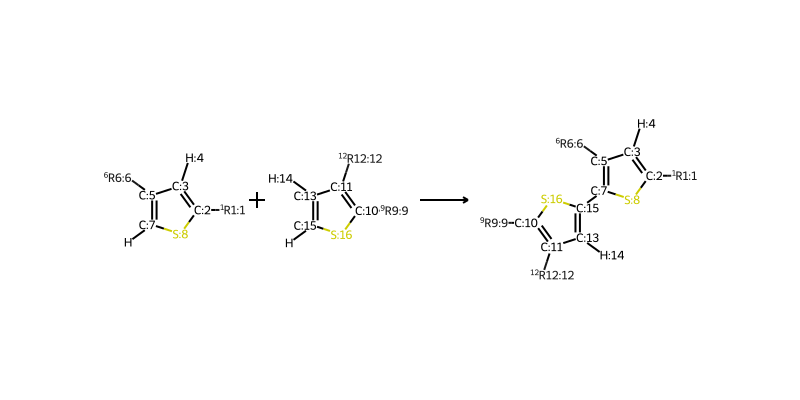

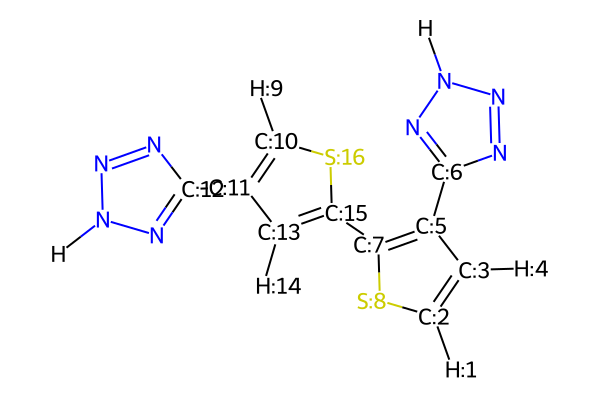

In [8]:
from polymerist.rdutils.reactions.reactions import AnnotatedReaction
from polymerist.rdutils.reactions.reactors import PolymerizationReactor


rxn = AnnotatedReaction.from_rxnfile(rxn_path) # notice here that we can use exactly he same RXN template, regardless of the chosen sidechain
reactor = PolymerizationReactor(rxn)
display(rxn)

for product in reactor.react(reactants):
    display(product)

### Enumerate all possible monomer fragments according to the defined polymerization reaction 

Cleaned 14 SMARTS atom query aberrations introduced by RDKit


poly-5-thiophen-3-yl-2h-tetrazole_head_TERM


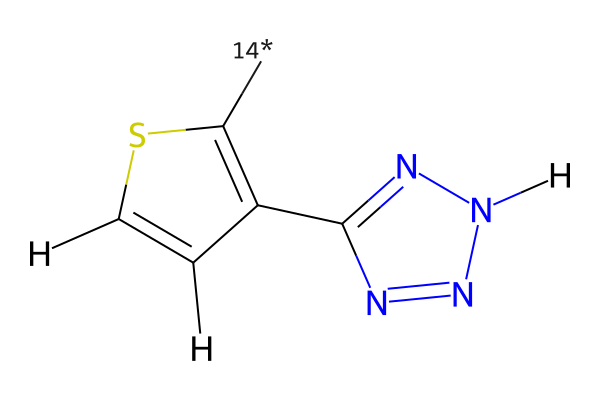

Cleaned 14 SMARTS atom query aberrations introduced by RDKit


poly-5-thiophen-3-yl-2h-tetrazole_tail_TERM


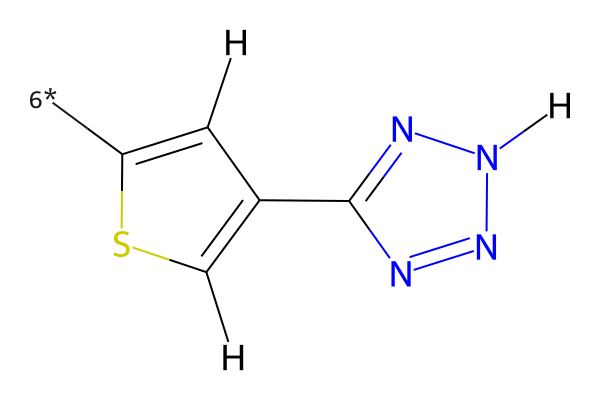

Cleaned 14 SMARTS atom query aberrations introduced by RDKit


poly-5-thiophen-3-yl-2h-tetrazole_head_MID


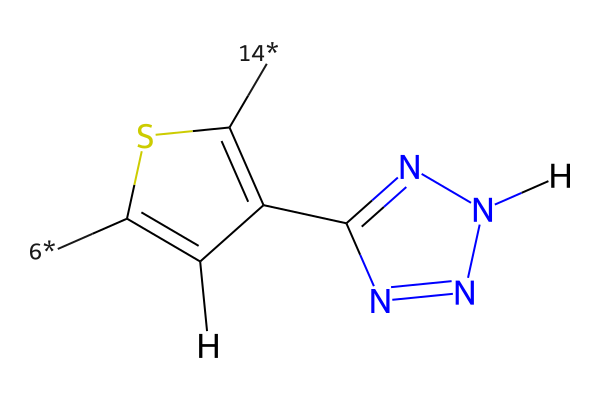

Cleaned 14 SMARTS atom query aberrations introduced by RDKit


poly-5-thiophen-3-yl-2h-tetrazole_tail_MID


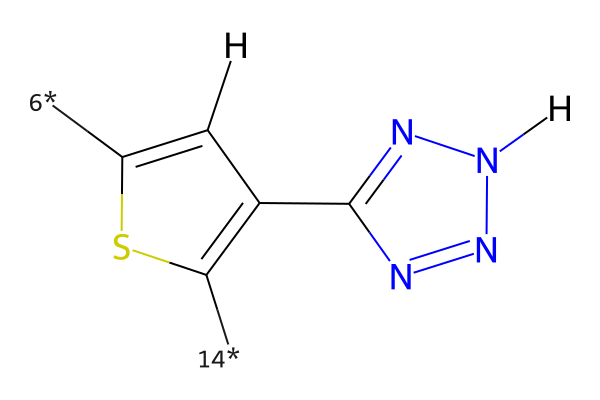

In [9]:
from polymerist.monomers import MonomerGroup
from polymerist.monomers.specification import expanded_SMILES, compliant_mol_SMARTS


monogrp = MonomerGroup()
rdkdraw.disable_substruct_highlights()
for dimers, fragments in reactor.propagate(reactants):
    for group_name, fragment in zip(reactants_dict.keys(), fragments):
        raw_smiles = Chem.MolToSmiles(fragment)
        exp_smiles = expanded_SMILES(raw_smiles)
        spec_smarts = compliant_mol_SMARTS(exp_smiles)
        
        affix = 'TERM' if MonomerGroup.is_terminal(fragment) else 'MID'
        frag_name = f'poly-{group_name}_{affix}'
        monogrp.monomers[frag_name] = [spec_smarts]

        print(frag_name)
        display(fragment)

fragment_path = assemble_path(RXNS_DIR, f'{polymer_name}_fragments', extension='json')
monogrp.to_file(fragment_path)

## Building a thiophene PDB of arbitrary DOP from fragments

In [10]:
from polymerist.monomers import MonomerGroup
from polymerist.polymers.building import build_linear_polymer, mbmol_to_openmm_pdb


# these are for you to configure
DOP : int = 15
do_energy_min : bool = False # this will make PDB generation much slower but give much more physical structures_{seq}

monogrp = MonomerGroup.from_file(fragment_path)
polymer = build_linear_polymer(
    monomers=monogrp,
    DOP=DOP,      # accounts for additional terminal monomer
    sequence='A', # accounts for head-tailedness at end groups
    energy_minimize=do_energy_min
)

polymer_path = assemble_path(RXNS_DIR, f'{polymer_name}_{DOP}-mer', extension='pdb')
mbmol_to_openmm_pdb(polymer_path, polymer)

No valid terminal monomer orientations defined; autogenerated orientations "{'poly-5-thiophen-3-yl-2h-tetrazole_head_TERM': 'head', 'poly-5-thiophen-3-yl-2h-tetrazole_tail_TERM': 'tail'}"; USER SHOULD VERIFY THIS YIELDS A CHEMICALLY-VALID POLYMER!
